<a href="https://colab.research.google.com/github/EfthymiosCosta/Neural-Networks-Weight-Uncertainty/blob/main/Bayesian_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import os
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [3]:
x_train=x_train/126
x_test=x_test/126
x_train=x_train.astype(np.float32)
x_test=x_test.astype(np.float32)
y_train_oh = tf.keras.utils.to_categorical(y_train)
y_test_oh = tf.keras.utils.to_categorical(y_test)

In [13]:
x_train.shape

(60000, 28, 28)

In [20]:
def get_deterministic_model(input_shape, loss, optimizer, metrics):
    """
    This function should build and compile a CNN model according to the above specification. 
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    model = Sequential([
        Conv2D(kernel_size=(5, 5), filters=8, activation='relu', padding='VALID', input_shape=input_shape),
        MaxPooling2D(pool_size=(6, 6)),
        Flatten(),
        Dense(units=10, activation='softmax')
    ])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [15]:
import tensorflow_datasets as tfds
x_data=tfds.image_classification.MNIST


In [12]:
tf.random.set_seed(0)
deterministic_model = get_deterministic_model(
    input_shape=(28, 28,1), 
    loss=SparseCategoricalCrossentropy(), 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

In [6]:
deterministic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


In [21]:
img_rows=x_train[0].shape[0]
img_cols=x_test[0].shape[1]

X_train=x_train.reshape(x_train.shape[0],img_rows,img_cols,1)

X_test=x_test.reshape(x_test.shape[0],img_rows,img_cols,1)
Input_shape=(img_rows,img_cols,1)

In [22]:
deterministic_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3798 - accuracy: 0.8905
Epoch 2/5
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1290 - accuracy: 0.9603
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1066 - accuracy: 0.9671
Epoch 4/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0960 - accuracy: 0.9700
Epoch 5/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0887 - accuracy: 0.9724


In [23]:
print('Accuracy on MNIST test set: ',
      str(deterministic_model.evaluate(X_test, y_test, verbose=False)[1]))

Accuracy on MNIST test set:  0.9754999876022339


In [25]:
def nll(y_true, y_pred):
    """
    This function should return the negative log-likelihood of each sample
    in y_true given the predicted distribution y_pred. If y_true is of shape 
    [B, E] and y_pred has batch shape [B] and event_shape [E], the output 
    should be a Tensor of shape [B].
    """
    return -y_pred.log_prob(y_true)

In [26]:
## Bayesian CNN model

In [27]:
def get_convolutional_reparameterization_layer(input_shape, divergence_fn):
    """
    This function should create an instance of a Convolution2DReparameterization 
    layer according to the above specification. 
    The function takes the input_shape and divergence_fn as arguments, which should 
    be used to define the layer.
    Your function should then return the layer instance.
    """
    
    layer = tfpl.Convolution2DReparameterization(
                input_shape=input_shape, filters=8, kernel_size=(5, 5),
                activation='relu', padding='VALID',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
            )
    return layer

In [38]:
#we will use a custom prior: the "spike and slab" (also called a scale 
#mixture prior) distribution. This distribution has a density that is the 
#weighted sum of two normally distributed ones: one with a standard 
#deviation of 1 and one with a standard deviation of 10. In this way, 
#it has a sharp spike around 0


def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=0.1*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=0.75*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

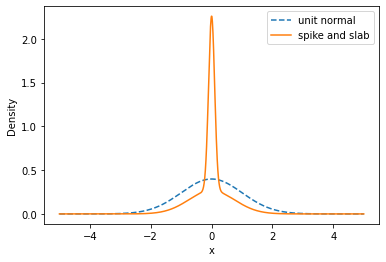

In [39]:
x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, spike_and_slab(1, dtype=tf.float32).prob(x_plot).numpy(), label='spike and slab')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

In [40]:
def get_prior(kernel_size, bias_size, dtype=None):
    """
    This function should create the prior distribution, consisting of the 
    "spike and slab" distribution that is described above. 
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the prior distribution.
    """
    n = kernel_size+bias_size  
    prior_model = Sequential([tfpl.DistributionLambda(lambda t : spike_and_slab(n, dtype))])
    return prior_model

In [41]:
def get_posterior(kernel_size, bias_size, dtype=None):
    """
    This function should create the posterior distribution as specified above.
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the posterior distribution.
    """
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

In [43]:
def get_dense_variational_layer(prior_fn, posterior_fn, kl_weight):
    """
    This function should create an instance of a DenseVariational layer according 
    to the above specification. 
    The function takes the prior_fn, posterior_fn and kl_weight as arguments, which should 
    be used to define the layer.
    Your function should then return the layer instance.
    """
    return tfpl.DenseVariational(
        units=10, make_posterior_fn=posterior_fn, make_prior_fn=prior_fn, kl_weight=kl_weight
    )

In [44]:
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]
convolutional_reparameterization_layer = get_convolutional_reparameterization_layer(
    input_shape=(28, 28, 1), divergence_fn=divergence_fn
)
dense_variational_layer = get_dense_variational_layer(
    get_prior, get_posterior, kl_weight=1/X_train.shape[0]
)

In [45]:
bayesian_model = Sequential([
    convolutional_reparameterization_layer,
    MaxPooling2D(pool_size=(6, 6)),
    Flatten(),
    dense_variational_layer,
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])
bayesian_model.compile(loss=nll,
              optimizer=RMSprop(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [46]:
bayesian_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_1  (None, 24, 24, 8)         416       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_variational_1 (DenseVa (None, 10)                2580      
_________________________________________________________________
one_hot_categorical_1 (OneHo multiple                  0         
Total params: 2,996
Trainable params: 2,996
Non-trainable params: 0
_________________________________________________________________


In [47]:
bayesian_model.fit(x=X_train, y=y_train_oh, epochs=10, verbose=True)

Epoch 1/10
1875/1875 [==============================] - 21s 10ms/step - loss: 2.1192 - accuracy: 0.2952
Epoch 2/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.8441 - accuracy: 0.7272
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.4637 - accuracy: 0.8580
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3351 - accuracy: 0.9019
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2812 - accuracy: 0.9214
Epoch 6/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2418 - accuracy: 0.9333
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2217 - accuracy: 0.9405
Epoch 8/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2068 - accuracy: 0.9460
Epoch 9/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1961 - accuracy: 0.9495
Epoch 10/10
1875/1875 [==============================] - 20s 11m

In [48]:
print('Accuracy on MNIST test set: ',
      str(bayesian_model.evaluate(X_test, y_test_oh, verbose=False)[1]))

Accuracy on MNIST test set:  0.957099974155426
